# Q1

In [1]:
!pip install yfinance
!pip install yfinance --upgrade --no-cache-dir

     |████████████████████████████████| 6.4 MB 36.6 MB/s 
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [84]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

In [85]:
train_dataframe = yf.download("BTC-USD", start="2014-01-01", end="2021-09-01")
val_dataframe = yf.download("BTC-USD", start="2021-09-01")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [86]:

def gen_past(data, n):
  n_data = len(data)
  x = []
  y = []
  last_element_idx = n_data - n
  # print(n_data)
  # print(last_element_idx)
  for index in range(0, last_element_idx):
    # print(index)
    x.append(
        data[index : index + n] #get past n data for predict next one 
    )
    # print("after")
    # print(len(data))
    # print(data[40])
    y.append(
        data[index + n] #get n'th data
    )
    # print("after1")

  return x, y

Date
2017-11-09     7143.580078
2017-11-10     6618.140137
2017-11-11     6357.600098
2017-11-12     5950.069824
2017-11-13     6559.490234
                  ...     
2021-08-28    48902.402344
2021-08-29    48829.832031
2021-08-30    47054.984375
2021-08-31    47166.687500
2021-09-01    48847.027344
Name: Close, Length: 1393, dtype: float64


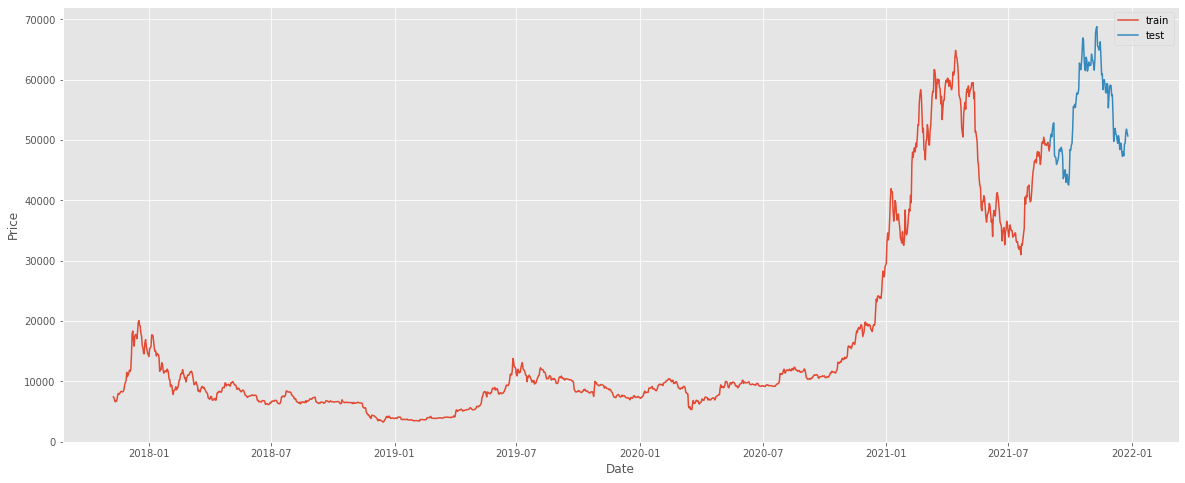

In [87]:
print(train_dataframe.Close)

#plot the data similar to the question
with plt.style.context('ggplot'): #ggplot is good for visualization
  fig, ax = plt.subplots(figsize=(20, 8))

  ax.plot(train_dataframe["High"], label='train')
  ax.plot(val_dataframe["High"], label='test')
  ax.set_ylabel("Price")
  ax.set_xlabel("Date")
  ax.legend()

In [88]:
from sklearn.preprocessing import MinMaxScaler


train_set = train_dataframe["High"].values.reshape(-1, 1)
val_set = val_dataframe["High"].values.reshape(-1, 1)

scaler = MinMaxScaler()
scaler.fit(train_set)
train_final = scaler.fit_transform(train_set)
val_final = scaler.fit_transform(val_set)

print(train_final.shape)
print(val_final.shape)


(1393, 1)
(117, 1)


In [29]:
import tensorflow as tf


def model_factory(input_shape):

  model = tf.keras.Sequential(
      [
       tf.keras.layers.LSTM(input_shape=input_shape, units=50, return_sequences=True),
       tf.keras.layers.Dropout(rate=0.2),
       tf.keras.layers.LSTM(units=50, return_sequences=True),
       tf.keras.layers.Dropout(rate=0.2),
       tf.keras.layers.LSTM(units=50, return_sequences=True),
       tf.keras.layers.Dropout(rate=0.2),
       tf.keras.layers.LSTM(units=50, return_sequences=False),
       tf.keras.layers.Dense(units=1)
      ]
  )

  model.summary()
  model.compile(loss="mean_squared_error", optimizer='adam')
  return model

In [30]:

past = 60
x_train, y_train = gen_past(train_final, past)
x_train = np.array(x_train) 
y_train = np.array(y_train) 

print(f"train shapes is x={x_train.shape}, y={y_train.shape}")

x_test, y_test = gen_past(val_final, past)
x_test = np.array(x_test) 
y_test = np.array(y_test) 

print(f"test shapes is x={x_test.shape}, y={y_test.shape}")


model = model_factory((past, 1))
history = model.fit(x_train, y_train, epochs=100, batch_size=32)


train shapes is x=(1333, 60, 1), y=(1333, 1)
test shapes is x=(57, 60, 1), y=(57, 1)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 60, 50)            10400     
                                                                 
 dropout_3 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_5 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_4 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_6 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_5 (Dropout)         (None, 60, 50)            0         
                                   

In [71]:

#since we normalize data we should scale back data to original data
def predict_without_model_method(model, x_train, val_test, past):

  all_predicts = []
  last_train = x_train[-1] #it has size of past

  print(last_train.shape)

  #we should reshape due to model input output
  last_train = last_train.reshape(1, past, 1)

  for idx in range(0, len(val_test)):
    predict = model(last_train)
    last_train = np.append(last_train, val_final[idx])
    last_train = last_train[1:] #delete old data
    last_train = last_train.reshape(1, past, 1)
    predict = predict.numpy()
    all_predicts.append(predict)


  return all_predicts

all_predictions = predict_without_model_method(model, x_train, val_final, past)

(60, 1)


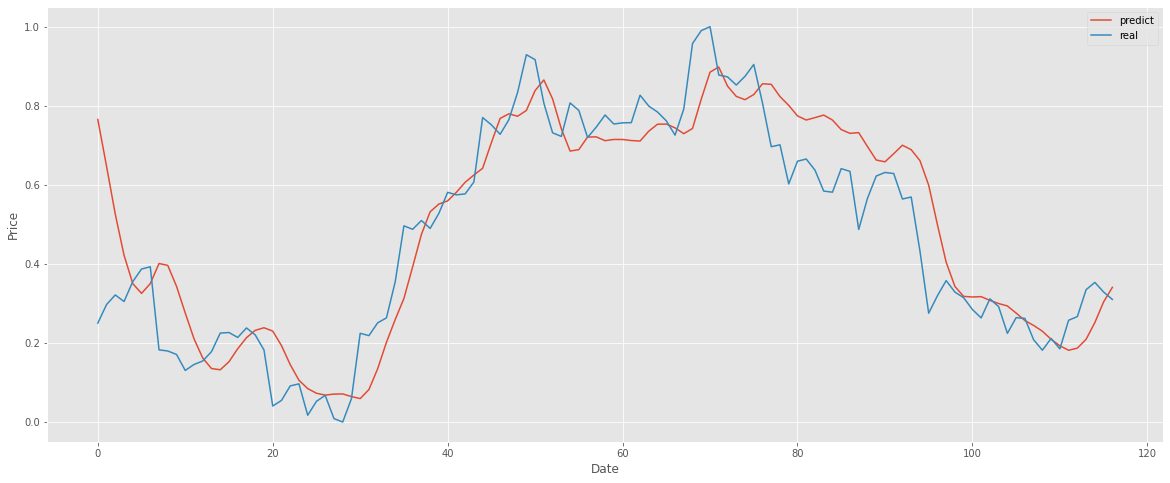

In [72]:
# print(all_predictions)
arrr = np.array([])
for arr in all_predictions:
  arrr = np.append(arrr, arr[0])
# print(val_final)
#plot the data similar to the question
with plt.style.context('ggplot'): #ggplot is good for visualization
  fig, ax = plt.subplots(figsize=(20, 8))

  ax.plot(arrr, label='predict')
  ax.plot(val_final, label='real')
  ax.set_ylabel("Price")
  ax.set_xlabel("Date")
  ax.legend()

In [89]:
future = 90
#since we normalize data we should scale back data to original data
def predict_without_model_method_future(model, val_test, past, future):

  all_predicts = []
  last_train = val_test[len(val_test) - past:] #it has size of past

  print(last_train.shape)

  #we should reshape due to model input output
  last_train = last_train.reshape(1, past, 1)

  for idx in range(0, future):
    predict = model(last_train)
    predict = predict.numpy()
    # print(predict.shape)
    predict = predict[0]
    last_train = np.append(last_train, predict) #since we dont have val_final so we should consider prediction
    last_train = last_train[1:] #delete old data
    last_train = last_train.reshape(1, past, 1)
    all_predicts.append(predict)


  return all_predicts

all_predictions = predict_without_model_method_future(model, val_final, past, future)

(60, 1)


117


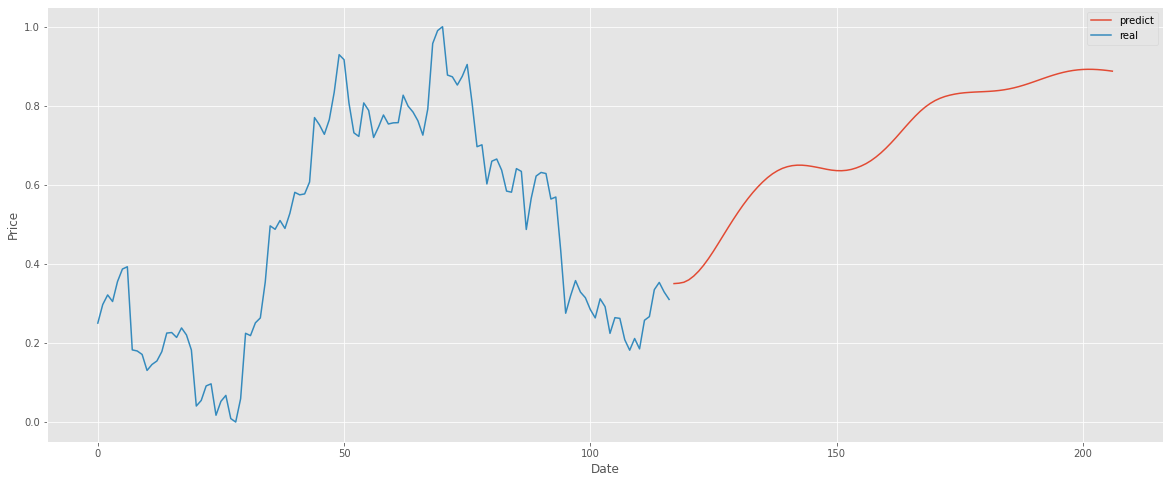

In [90]:
# print(all_predictions)
# print(val_final)
# arrr = np.array([])
# for arr in all_predictions:
#   arrr = np.append(arrr, arr[0])
# print(val_final)
#plot the data similar to the question
print(len(val_final))
x_shift = []

for idx in range(0, len(all_predictions)):
  x_shift.append(len(val_final) + idx)
with plt.style.context('ggplot'): #ggplot is good for visualization
  fig, ax = plt.subplots(figsize=(20, 8))

  ax.plot(x_shift, all_predictions, label='predict')
  ax.plot(val_final, label='real')
  ax.set_ylabel("Price")
  ax.set_xlabel("Date")
  ax.legend()

In [91]:
past = 90
x_train, y_train = gen_past(train_final, past)
x_train = np.array(x_train) 
y_train = np.array(y_train) 

print(f"train shapes is x={x_train.shape}, y={y_train.shape}")

x_test, y_test = gen_past(val_final, past)
x_test = np.array(x_test) 
y_test = np.array(y_test) 

print(f"test shapes is x={x_test.shape}, y={y_test.shape}")


model = model_factory((past, 1))
history = model.fit(x_train, y_train, epochs=100, batch_size=32)

train shapes is x=(1303, 90, 1), y=(1303, 1)
test shapes is x=(27, 90, 1), y=(27, 1)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 90, 50)            10400     
                                                                 
 dropout_6 (Dropout)         (None, 90, 50)            0         
                                                                 
 lstm_9 (LSTM)               (None, 90, 50)            20200     
                                                                 
 dropout_7 (Dropout)         (None, 90, 50)            0         
                                                                 
 lstm_10 (LSTM)              (None, 90, 50)            20200     
                                                                 
 dropout_8 (Dropout)         (None, 90, 50)            0         
                                   

In [92]:
all_predictions = predict_without_model_method(model, x_train, val_final, past)

(90, 1)


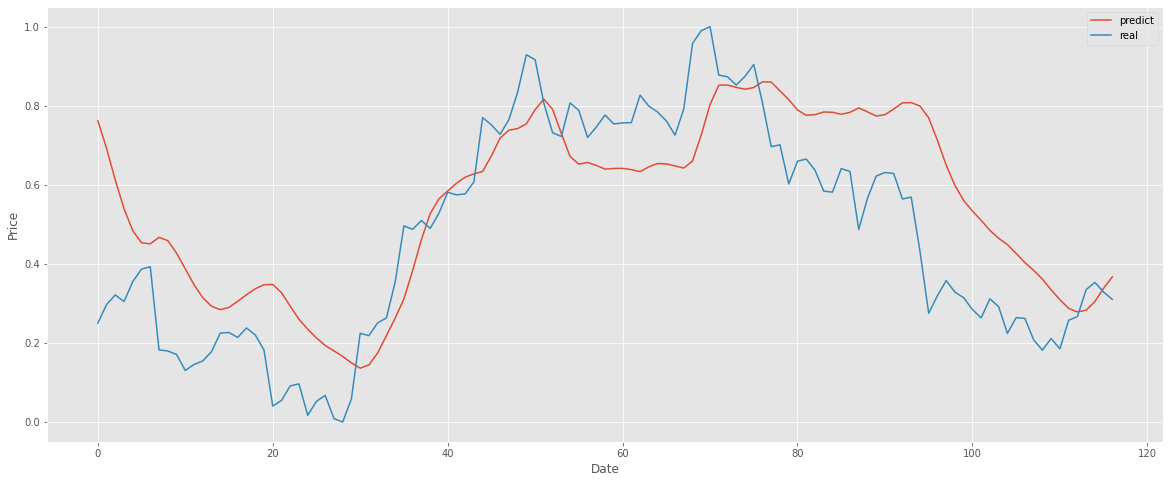

In [93]:
# print(all_predictions)
arrr = np.array([])
for arr in all_predictions:
  arrr = np.append(arrr, arr[0])
# print(val_final)
#plot the data similar to the question
with plt.style.context('ggplot'): #ggplot is good for visualization
  fig, ax = plt.subplots(figsize=(20, 8))

  ax.plot(arrr, label='predict')
  ax.plot(val_final, label='real')
  ax.set_ylabel("Price")
  ax.set_xlabel("Date")
  ax.legend()

In [94]:
all_predictions = predict_without_model_method_future(model, val_final, past, future)

(90, 1)


117


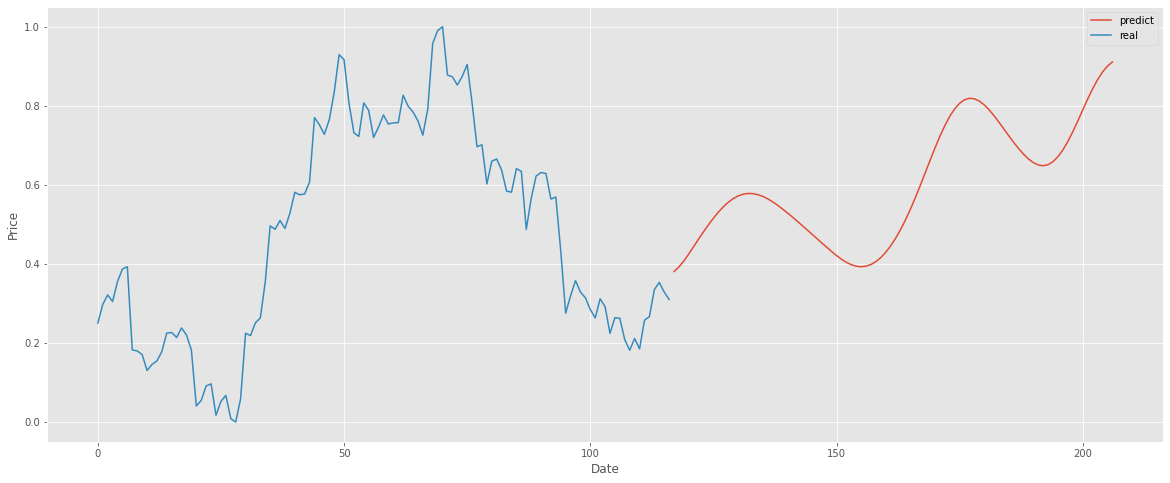

In [95]:
# print(all_predictions)
# print(val_final)
# arrr = np.array([])
# for arr in all_predictions:
#   arrr = np.append(arrr, arr[0])
# print(val_final)
#plot the data similar to the question
print(len(val_final))
x_shift = []

for idx in range(0, len(all_predictions)):
  x_shift.append(len(val_final) + idx)
with plt.style.context('ggplot'): #ggplot is good for visualization
  fig, ax = plt.subplots(figsize=(20, 8))

  ax.plot(x_shift, all_predictions, label='predict')
  ax.plot(val_final, label='real')
  ax.set_ylabel("Price")
  ax.set_xlabel("Date")
  ax.legend()

# Q2

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

In [2]:
uploaded = files.upload()

Saving enc-dec.txt to enc-dec.txt


In [7]:

#open and read and split

all_encode_symbols = "abcdefghijklmnopqrstuvwxyz "

encrypt_data = []
decrypt_data = []

f = open("./enc-dec.txt", "r")
content = f.read()

lines = content.splitlines()

for line in lines:
  encrypted_msg, decrypted_msg = line.split("\t")

  if len(decrypted_msg) != 10:
    for i in range(0, 10 - len(decrypted_msg)):
      decrypted_msg += " "

  result_of_one_hot = np.zeros((len(decrypted_msg), len(all_encode_symbols)))
  for i in range(len(decrypted_msg)):
    result_of_one_hot[i, all_encode_symbols.find(decrypted_msg[i])] = 1

  
  decrypt_data.append(result_of_one_hot)

  if len(encrypted_msg) != 10:
    for i in range(0, 10 - len(encrypted_msg)):
      encrypted_msg += " "

  result_of_one_hot = np.zeros((len(encrypted_msg), len(all_encode_symbols)))
  for i in range(len(encrypted_msg)):
    result_of_one_hot[i, all_encode_symbols.find(encrypted_msg[i])] = 1

  encrypt_data.append(result_of_one_hot)


encrypt_data = np.array(encrypt_data) 
decrypt_data = np.array(decrypt_data) 

print(f"shape encrypt is: {encrypt_data.shape}")
print(f"shape decrypt is: {decrypt_data.shape}")

shape encrypt is: (152273, 10, 27)
shape decrypt is: (152273, 10, 27)


In [11]:
import tensorflow as tf
model = tf.keras.Sequential(
    [
      tf.keras.layers.GRU(units=128, return_sequences=True, input_shape=(10, len(all_encode_symbols))),
      tf.keras.layers.GRU(units=256, return_sequences=True),
      tf.keras.layers.GRU(units=256, return_sequences=True),
      tf.keras.layers.Dense(units=len(all_encode_symbols), activation="softmax")
    ]
)

model.summary()
model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 10, 128)           60288     
                                                                 
 gru_1 (GRU)                 (None, 10, 256)           296448    
                                                                 
 gru_2 (GRU)                 (None, 10, 256)           394752    
                                                                 
 dense (Dense)               (None, 10, 27)            6939      
                                                                 
Total params: 758,427
Trainable params: 758,427
Non-trainable params: 0
_________________________________________________________________


In [12]:
history = model.fit(encrypt_data, decrypt_data, epochs=8, batch_size=32)

Epoch 1/8
4759/4759 [==============================] - 94s 18ms/step - loss: 0.5154 - accuracy: 0.8645
Epoch 2/8
4759/4759 [==============================] - 85s 18ms/step - loss: 0.2129 - accuracy: 0.9515
Epoch 3/8
4759/4759 [==============================] - 85s 18ms/step - loss: 0.2102 - accuracy: 0.9524
Epoch 4/8
4759/4759 [==============================] - 85s 18ms/step - loss: 0.2086 - accuracy: 0.9529
Epoch 5/8
4759/4759 [==============================] - 85s 18ms/step - loss: 0.2077 - accuracy: 0.9532
Epoch 6/8
4759/4759 [==============================] - 84s 18ms/step - loss: 0.2073 - accuracy: 0.9534
Epoch 7/8
4759/4759 [==============================] - 87s 18ms/step - loss: 0.2066 - accuracy: 0.9536
Epoch 8/8
4759/4759 [==============================] - 84s 18ms/step - loss: 0.2063 - accuracy: 0.9537


In [13]:
encrypt = "onmltsrqpoihgrezcba lknrvjihgfueiizltflk"
split = []

def wrap(s, w):
  return [s[i:i + w] for i in range(0, len(s), w)]

split = wrap(encrypt, 10)

print(split)

['onmltsrqpo', 'ihgrezcba ', 'lknrvjihgf', 'ueiizltflk']


In [31]:

final = []

for word in split:
  result_of_one_hot = np.zeros((len(word), len(all_encode_symbols)))
  for i in range(len(word)):
    result_of_one_hot[i, all_encode_symbols.find(word[i])] = 1

  result_of_one_hot = result_of_one_hot.reshape(1, result_of_one_hot.shape[0], result_of_one_hot.shape[1])
  # print(result_of_one_hot.shape)
  predict = model(result_of_one_hot)

  # print(np.argmax(predict, axis=0))
  # print(np.argmax(predict, axis=1))
  # print(np.argmax(predict, axis=2))
  all_predict = np.argmax(predict, axis=2)
  word = ""
  # print(all_predict[0])
  for idx in all_predict[0]:
    # print(idx)
    word += all_encode_symbols[idx]

  final.append(word)
  # print(predict)


print("".join(word for word in final))

    i        love     deep     learning 
